# Nowcasting with Mixed Monthly/Quarterly data
Quarterly GDP forecast with monthly data. It is inspired by a script of [Chan Fulton](https://www.chadfulton.com/topics/statespace_large_dynamic_factor_models.html).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import statsmodels.tsa.api as tsa

import warnings
warnings.simplefilter('ignore')

In [2]:
codes = pd.read_excel('series.xlsx', sheet_name='Series')

dta = {
    '2023-05': pd.read_pickle('Data/monthly/data_st_2023_05.pkl'),
    '2023-06': pd.read_pickle('Data/monthly/data_st_2023_06.pkl'),
    '2023-07': pd.read_pickle('Data/monthly/data_st_2023_07.pkl'),
    '2023-08': pd.read_pickle('Data/monthly/data_st_2023_08.pkl'),
    '2023-09': pd.read_pickle('Data/monthly/data_st_2023_09.pkl'),
    '2023-10': pd.read_pickle('Data/monthly/data_st_2023_10.pkl'),
    '2023-11': pd.read_pickle('Data/monthly/data_st_2023_11.pkl'),
    '2023-12': pd.read_pickle('Data/monthly/data_st_2023_12.pkl'),
    '2024-01': pd.read_pickle('Data/monthly/data_st_2024_01.pkl'),
    '2024-02': pd.read_pickle('Data/monthly/data_st_2024_02.pkl'),
    '2024-03': pd.read_pickle('Data/monthly/data_st_2024_03.pkl'),
}
dta_gdp = {
    '2023-05': pd.read_pickle('Data/quarterly/gdp_st_2023_05.pkl'),
    '2023-06': pd.read_pickle('Data/quarterly/gdp_st_2023_06.pkl'),
    '2023-07': pd.read_pickle('Data/quarterly/gdp_st_2023_07.pkl'),
    '2023-08': pd.read_pickle('Data/quarterly/gdp_st_2023_08.pkl'),
    '2023-09': pd.read_pickle('Data/quarterly/gdp_st_2023_09.pkl'),
    '2023-10': pd.read_pickle('Data/quarterly/gdp_st_2023_10.pkl'),
    '2023-11': pd.read_pickle('Data/quarterly/gdp_st_2023_11.pkl'),
    '2023-12': pd.read_pickle('Data/quarterly/gdp_st_2023_12.pkl'),
    '2024-01': pd.read_pickle('Data/quarterly/gdp_st_2024_01.pkl'),
    '2024-02': pd.read_pickle('Data/quarterly/gdp_st_2024_02.pkl'),
    '2024-03': pd.read_pickle('Data/quarterly/gdp_st_2024_03.pkl'),
}

In [3]:
# Declarations -> Current month
df_m  = dta['2024-03']
df_q  = dta_gdp['2024-03']

# Edit
df_q = pd.DataFrame( df_q['2015Q2':] )

codes.head()

,Group,Code,Description,Source,Measure,Frequency,Tcode
0,Output,PN01756AM,Producto: Agrícola,BCRP,Índice 2007=100,Mensual,4+
1,Output,PN01757AM,Producto: Pecuario,BCRP,Índice 2007=100,Mensual,4+
2,Output,PN01758AM,Producto: Pesca,BCRP,Índice 2007=100,Mensual,4+
3,Output,PN01760AM,Producto: Minería Metálica,BCRP,Índice 2007=100,Mensual,4+
4,Output,PN01761AM,Producto: Hidrocarburos,BCRP,Índice 2007=100,Mensual,4+


In [4]:
df_m.tail()

,Producto: Agrícola,Producto: Pecuario,Producto: Pesca,Producto: Minería Metálica,Producto: Hidrocarburos,Producto: Manufactura Procesadores Recursos Primarios,Producto: Manufactura no Primaria,Producto: Electricidad y Agua,Producto: Construcción,Producto: Comercio,...,6-Month Treasury Bill,1-Year Treasury Rate,5-Year Treasury Rate,10-Year Treasury Rate,Indice de Dólar,S&P 500,Dow Jones Industrial Average,NASDAQ Composite,FTSE 100,Nikkei 225
2023-11,-0.145648,-0.155036,-0.279529,-0.929310,0.047176,0.896756,0.091047,0.721995,-0.596609,0.700998,...,2.187189,2.160452,2.157849,2.306881,-1.230269,0.975794,0.912381,0.950847,-0.189158,0.985982
2023-12,-0.151003,-0.161366,-0.291519,-0.930571,0.050044,0.866930,0.096083,0.737175,-0.606773,0.714047,...,2.115227,1.966719,1.727906,1.798180,-1.262690,1.128729,1.509190,0.989942,0.583309,-0.064513
2024-01,-0.156339,-0.167640,-0.303526,-0.928924,0.056766,0.836566,0.105690,0.753333,-0.619498,0.724739,...,2.055259,1.863798,1.710358,1.840572,0.126849,0.463238,0.398147,0.344568,-0.069010,1.436075
2024-02,-0.161506,-0.173684,-0.315269,-0.925931,0.067637,0.807813,0.120367,0.770716,-0.632951,0.733586,...,2.097237,1.942502,1.894619,1.999541,0.675877,0.936669,0.484457,0.823438,0.112552,1.332968
2024-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.619791,0.424769,-0.110585,0.196247,0.175361,0.809956


In [5]:
# Adding GDP Growth -> Monthly variable which will be generated
codes = codes.append(
    {
        'Description': 'GDP Growth',
        'Group': 'Output'
    },
    ignore_index=True
)


# Groups!
codes[['Group', 'Description']].groupby('Group', sort=False).count()

,Description
Group,
Output,13
Labor Market,21
Juncture,14
Prices,13
Government,11
Balance of Trade,17
Finance,24
Stock Market,6
Quotes,11


In [6]:
# Assignment of groups and a `Global` one
factors = {row['Description']: ['Global', row['Group']] for ix, row in codes.iterrows()}

# Amount of factor per groups
factor_multiplicities = {
    'Global': 2,
    'Output': 1,
    'Labor Market': 1,
    'Juncture': 1,
    'Prices': 1,
    'Government': 1,
    'Balance of Trade': 1,
    'Finance': 1,
    'Stock Market': 1,
    'Quotes': 1
}

# AR(p) order of idiosyncratic disturbances
factor_orders = {
    ('Output', 'Labor Market', 'Juncture', 'Prices', 'Government',
     'Balance of Trade', 'Finance', 'Stock Market', 'Quotes'): 2,
    'Global': 1
}

In [7]:
factors

{'Producto: Agrícola': ['Global', 'Output'],
 'Producto: Pecuario': ['Global', 'Output'],
 'Producto: Pesca': ['Global', 'Output'],
 'Producto: Minería Metálica': ['Global', 'Output'],
 'Producto: Hidrocarburos': ['Global', 'Output'],
 'Producto: Manufactura Procesadores Recursos Primarios': ['Global', 'Output'],
 'Producto: Manufactura no Primaria': ['Global', 'Output'],
 'Producto: Electricidad y Agua': ['Global', 'Output'],
 'Producto: Construcción': ['Global', 'Output'],
 'Producto: Comercio': ['Global', 'Output'],
 'Producto: Otros Servicios': ['Global', 'Output'],
 'Producto: Derechos de Importación y otros Impuestos': ['Global', 'Output'],
 'PEA Ocupada - Por Edad - 14 a 24 años': ['Global', 'Labor Market'],
 'PEA Ocupada - Por Edad - 25 a 44 años': ['Global', 'Labor Market'],
 'PEA Ocupada - Por Edad - 45 a más años': ['Global', 'Labor Market'],
 'PEA Ocupada - Por Categoría Ocupacional - Independiente': ['Global',
  'Labor Market'],
 'PEA Ocupada - Por Categoría Ocupacional - 

In [8]:
factor_multiplicities

{'Global': 2,
 'Output': 1,
 'Labor Market': 1,
 'Juncture': 1,
 'Prices': 1,
 'Government': 1,
 'Balance of Trade': 1,
 'Finance': 1,
 'Stock Market': 1,
 'Quotes': 1}

In [9]:
factor_orders

{('Output',
  'Labor Market',
  'Juncture',
  'Prices',
  'Government',
  'Balance of Trade',
  'Finance',
  'Stock Market',
  'Quotes'): 2,
 'Global': 1}

## Dynamic Factor MQ model

In [10]:
# Declaration
model = tsa.DynamicFactorMQ(
    endog = df_m,
    endog_quarterly = df_q['GDP Growth'],
    factors = factors,
    factor_orders = factor_orders,
    factor_multiplicities = factor_multiplicities
)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Model Specification: Dynamic Factor Model                          
============================================================================================
Model:                 Dynamic Factor Model   # of monthly variables:                    129
                   + 11 factors in 2 blocks   # of quarterly variables:                    1
                    + Mixed frequency (M/Q)   # of factor blocks:                          2
                      + AR(1) idiosyncratic   Idiosyncratic disturbances:              AR(1)
Sample:                             2015-01   Standardize variables:                    True
                                  - 2024-03                                                 
                                                               Observed variables / factor loadings                                                               
==================================================================================================================================================================
              Dep. variable     Output Labor Market   Juncture      Prices  Government Balance of Trade    Finance Stock Market     Quotes    Global.1    Global.2
------------------------------------------------------------------------------------------------------------------------------------------------------------------
         Producto: Agrícola       X                                                                                                              X           X    
         Producto: Pecuario       X                                                                                                              X           X    
            Producto: Pesca       X                                                                                                              X           X    
Producto: Minería Metáli...       X                                                                                                              X           X    
    Producto: Hidrocarburos       X                                                                                                              X           X    
Producto: Manufactura Pr...       X                                                                                                              X           X    
Producto: Manufactura no...       X                                                                                                              X           X    
Producto: Electricidad y...       X                                                                                                              X           X    
     Producto: Construcción       X                                                                                                              X           X    
         Producto: Comercio       X                                                                                                              X           X    
Producto: Otros Servicio...       X                                                                                                              X           X    
Producto: Derechos de Im...       X                                                                                                              X           X    
PEA Ocupada - Por Edad -...                 X                                                                                                    X           X    
PEA Ocupada - Por Edad -...                 X                                                                                                    X           X    
PEA Ocupada - Por Edad -...                 X                                                                                                    X           X    
PEA Ocupada - Por Catego...                 X                                                                  

In [11]:
# Coefficients estimated
results = model.fit(disp=10)
results.summary()

EM start iterations, llf=-5039.8
EM iteration 10, llf=-1673.3, convergence criterion=0.0067855
EM iteration 20, llf=-1621.7, convergence criterion=0.0015532
EM iteration 30, llf=-1605, convergence criterion=0.00078868
EM iteration 40, llf=-1595, convergence criterion=0.00050222
EM iteration 50, llf=-1588.8, convergence criterion=0.00032083
EM iteration 60, llf=-1584.7, convergence criterion=0.00021727
EM iteration 70, llf=-1581.8, convergence criterion=0.00015934
EM iteration 80, llf=-1579.6, convergence criterion=0.00012481
EM iteration 90, llf=-1577.8, convergence criterion=0.00010268
EM iteration 100, llf=-1576.3, convergence criterion=8.7625e-05
EM iteration 110, llf=-1575, convergence criterion=7.6854e-05
EM iteration 120, llf=-1573.9, convergence criterion=6.8724e-05
EM iteration 130, llf=-1572.9, convergence criterion=6.2193e-05
EM iteration 140, llf=-1571.9, convergence criterion=5.661e-05
EM iteration 150, llf=-1571.1, convergence criterion=5.1608e-05
EM iteration 160, llf=-15

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    Dynamic Factor Results                                    
==============================================================================================
Dep. Variable:     "Producto: Agrícola", and 129 more   No. Observations:                  111
Model:                           Dynamic Factor Model   Log Likelihood               -1561.705
                             + 11 factors in 2 blocks   AIC                           4851.410
                              + Mixed frequency (M/Q)   BIC                           7192.444
                                + AR(1) idiosyncratic   HQIC                          5801.098
Date:                                Sun, 17 Mar 2024   EM Iterations                      500
Time:                                        19:43:47                                         
Sample:                                    01-31-2015                                         
                                         - 03-31-2024                                         
Covariance Type:                         Not computed                                         
                                                                                        Observation equation:                                                                                        
=====================================================================================================================================================================================================
           Factor loadings:     Output Labor Market   Juncture      Prices  Government Balance of Trade    Finance Stock Market     Quotes    Global.1    Global.2    idiosyncratic: AR(1)       var.
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
         Producto: Agrícola      -0.17            .          .           .           .                .          .            .          .        0.18       -0.00                    0.96       0.02
         Producto: Pecuario      -0.18            .          .           .           .                .          .            .          .        0.18        0.00                    0.97       0.01
            Producto: Pesca      -0.20            .          .           .           .                .          .            .          .        0.16        0.02                    0.96       0.02
Producto: Minería Metáli...      -0.13            .          .           .           .                .          .            .          .        0.13        0.10                    0.95       0.02
    Producto: Hidrocarburos      -0.38            .          .           .           .                .          .            .          .       -0.01       -0.04                    0.95       0.00
Producto: Manufactura Pr...      -0.19            .          .           .           .                .          .            .          .       -0.07       -0.09                    0.98       0.03
Producto: Manufactura no...      -0.36            .          .           .           .                .          .            .          .       -0.02        0.00                    0.98       0.00
Producto: Electricidad y...      -0.33            .          .           .           .                .          .            .          .       -0.10       -0.01                    0.99       0.01
     Producto: Construcción       0.32            .          .           .           .                .          .            .          .        0.01       -0.05                    0.98       0.01
         Producto: Comercio      -0.33            .          .           .           .                .          .            .          .       -0.09       -0.00                    0.99       0.01
Producto: Otros Servicio...      -0.36  

## Estimated Factors
After the estimation process, we can recover the factors with their respective confidence bands:

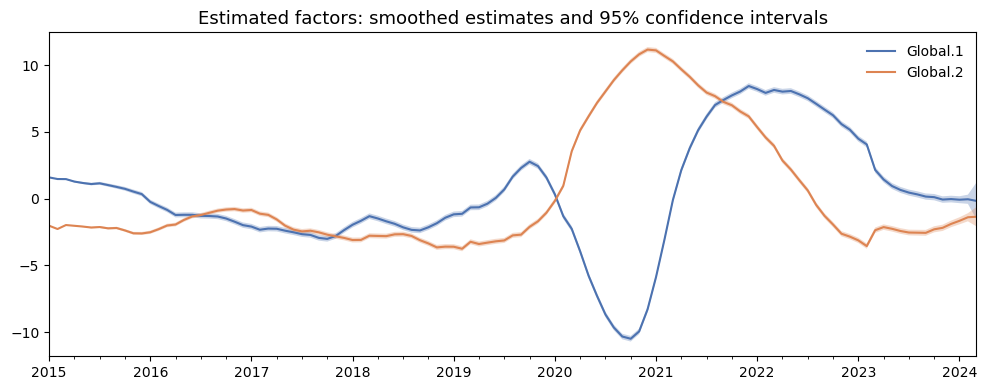

In [12]:
# Declaration
factor_names = ['Global.1', 'Global.2']


# Compute 95% confidence intervals
mean = results.factors.smoothed[factor_names]
std   = pd.concat([results.factors.smoothed_cov.loc[name, name] for name in factor_names], axis=1)
crit  = norm.ppf(1 - 0.05 / 2)
lower = mean - crit * std
upper = mean + crit * std


with sns.color_palette('deep'):
    fig, ax = plt.subplots(figsize=(10, 4))
    mean.plot(ax=ax)
    
    for name in factor_names:
        ax.fill_between(mean.index, lower[name], upper[name], alpha=0.3)

    plt.title('Estimated factors: smoothed estimates and 95% confidence intervals', fontsize=13)
    plt.legend(fontsize=10, edgecolor="white")
    
    fig.tight_layout()
    plt.plot()

## $R^2$ of individual factors
We can also review which are the most relevant indicators in each group/factor:

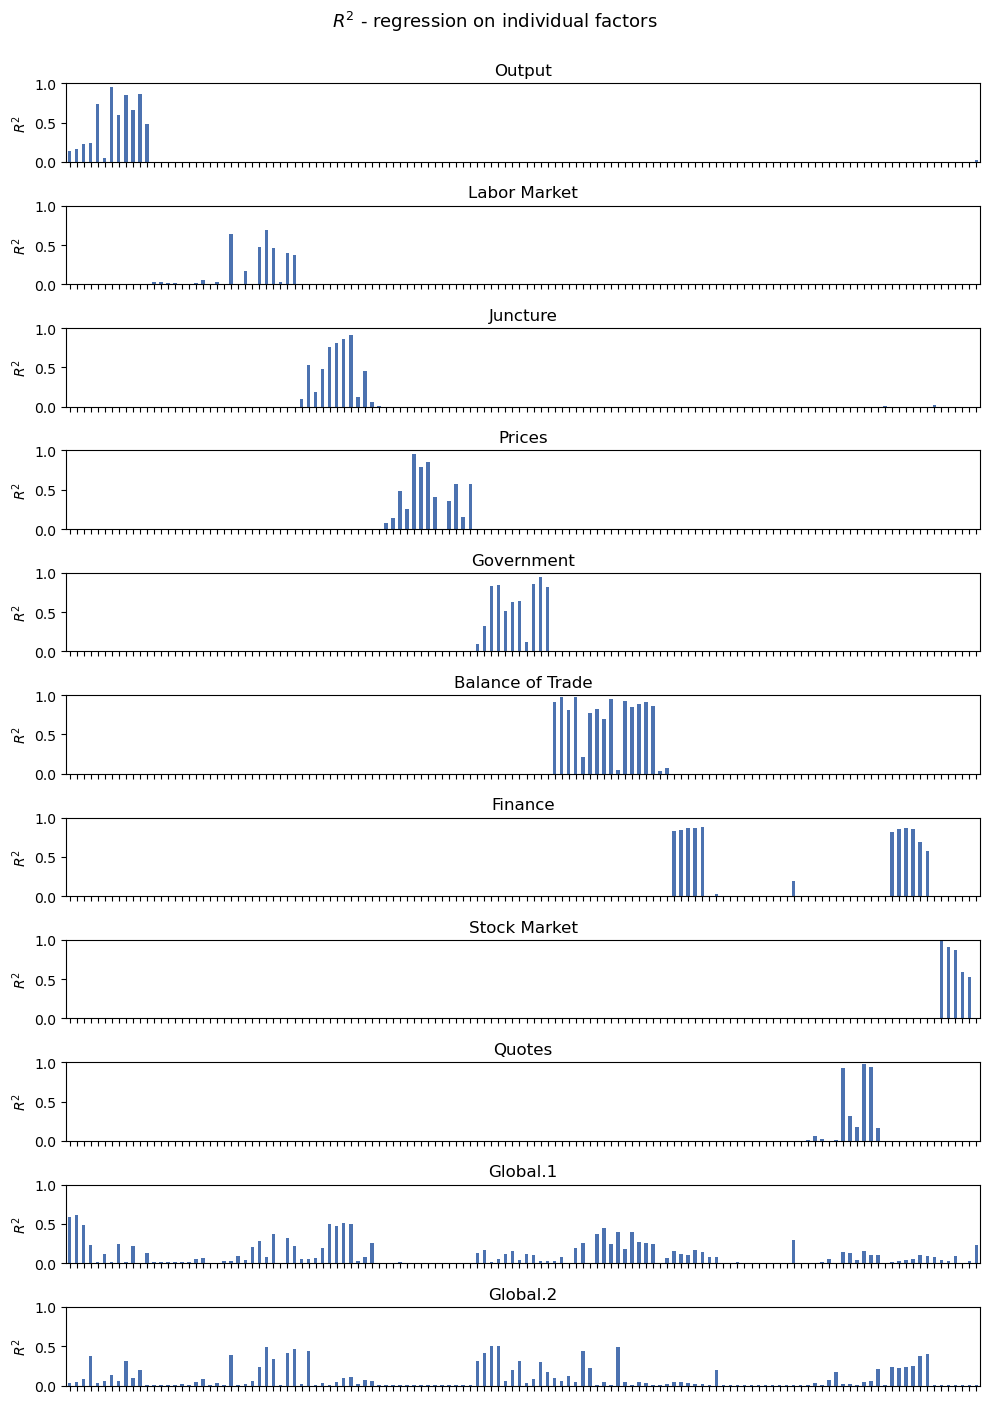

In [13]:
with sns.color_palette('deep'):
    fig = results.plot_coefficients_of_determination(method='individual', figsize=(10, 14))
    fig.suptitle(r'$R^2$ - regression on individual factors', fontsize=13, y=1)
    fig.tight_layout()

## Forecasting
Then, with the latest monthly data, the nowcasting models allow us to forecast with all the information possible:

In [14]:
first_period    = str(df_q.index[0])
last_period     = str(df_q.index[-1])
forecast_period = '2025Q4' # To define

print(f'Last oficial value on: {last_period}, and we estimated until {forecast_period}')

Last oficial value on: 2023Q4, and we estimated until 2025Q4


In [15]:
# Monthly GDP Growth estimated to Quarterly
forecast = results.forecast(forecast_period)['GDP Growth'].resample('Q').last()
h        = len(forecast)


# New GDP DataFrame ========================================================================
new_periods = pd.period_range(start=first_period, end=forecast_period, freq='Q')
df_q_f      = pd.DataFrame(index=new_periods, columns=['Real GDP', 'GDP Growth'])

# GDP Growth
df_q_f.loc[:last_period, 'Real GDP']   = df_q['Real GDP']
df_q_f.loc[:last_period, 'GDP Growth'] = df_q['GDP Growth']
df_q_f.loc[-h:, 'GDP Growth'] = forecast

# GDP 2024Q1 -> Only for this quarter
df_q_f.loc['2024Q1', 'GDP Growth'] = float(
    results.predict()[results.predict().index=='2024-03']['GDP Growth']
)

# Real GDP
last_real_gdp = df_q_f.loc[df_q_f['Real GDP'].last_valid_index(), 'Real GDP']

for i in range(len(df_q_f)):
    if df_q_f.index[i] >= pd.Period(last_period):
        previous_real_gdp = df_q_f.loc[df_q_f.index[i-4], 'Real GDP']
        gdp_growth = df_q_f.loc[df_q_f.index[i], 'GDP Growth']
        df_q_f.loc[df_q_f.index[i], 'Real GDP'] = previous_real_gdp * (1 + gdp_growth / 100)

df_q_f['Real GDP'] = df_q_f['Real GDP'].fillna(method='ffill')


# Check
print(f'\nReal GDP and Real GDP Growth\n(oficial until {last_period} and forecast):\n')
df_q_f.tail(12)


Real GDP and Real GDP Growth
(oficial until 2023Q4 and forecast):



,Real GDP,GDP Growth
2023Q1,132693.353417,-0.366927
2023Q2,140427.980194,-0.517726
2023Q3,142259.986803,-0.919113
2023Q4,148879.369818,-0.39492
2024Q1,135650.125786,2.228275
2024Q2,144431.582732,2.851001
2024Q3,145120.099863,2.010483
2024Q4,149642.789619,0.512777
2025Q1,135992.244690,0.252207
2025Q2,145460.173043,0.712164


In [16]:
print(f'\nAnnual forecast:\n')
pd.DataFrame(
    {
        'Real GDP': np.round( df_q_f['Real GDP'].resample('Y').sum(), 0),
        'GDP Growth': np.round( df_q_f['Real GDP'].resample('Y').sum().pct_change() * 100, 2)
    }
).loc['2022':]


Annual forecast:



,Real GDP,GDP Growth
2022,567390.0,2.68
2023,564261.0,-0.55
2024,574845.0,1.88
2025,581250.0,1.11


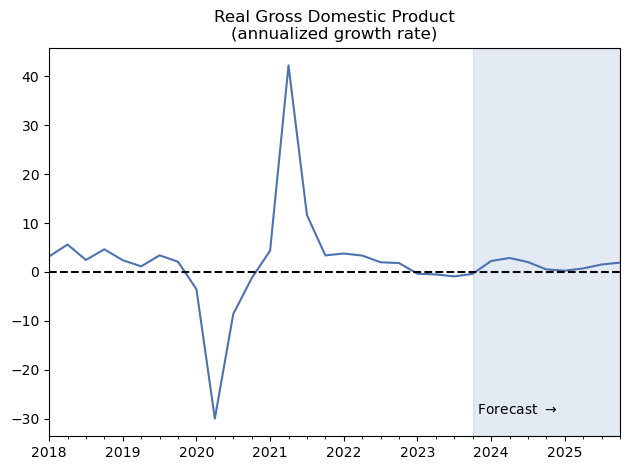

GDP Growth / Forecast: 
2023Q4    -0.39492
2024Q1    2.228275
2024Q2    2.851001
2024Q3    2.010483
2024Q4    0.512777
2025Q1    0.252207
2025Q2    0.712164
2025Q3    1.512084
2025Q4    1.898078
Freq: Q-DEC, Name: GDP Growth, dtype: object


In [20]:
xmin = '2018Q1'
xmax = '2025Q4'


with sns.color_palette('deep'):
    fig = plt.plot(figsize=(8, 5), dpi=600)

    # Plot GDP growth data: historic and forecast
    df_q_f.loc[xmin:xmax, 'GDP Growth'].plot()
    plt.title('Real Gross Domestic Product\n(annualized growth rate)')
    plt.axhline(y=0, color='black', linestyle='--')
   
    # Fill
    ylim = plt.ylim()
    plt.fill_between(df_q_f.loc[last_period:].index, ylim[0], ylim[1], alpha=0.15, color='C0')
    plt.annotate(r' Forecast $\rightarrow$', (last_period, ylim[0] + 0.1 * ylim[1]))
    plt.ylim(ylim[0], ylim[1])

    plt.tight_layout()
    plt.show()


print('GDP Growth / Forecast: ')
print(df_q_f['GDP Growth'].tail(h+2))

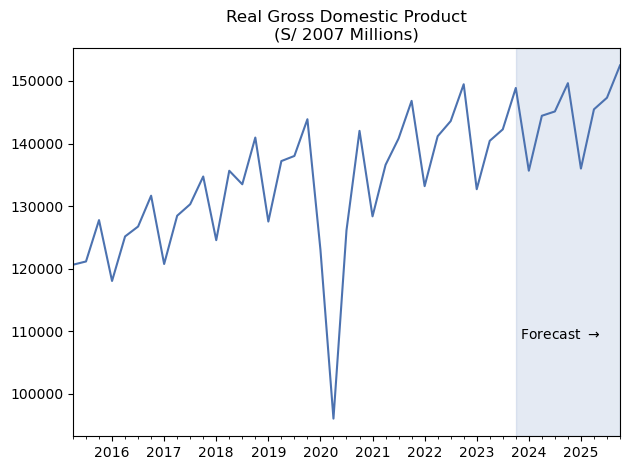

Real GDP / Forecast: 
2023Q4    148879.369818
2024Q1    135650.125786
2024Q2    144431.582732
2024Q3    145120.099863
2024Q4    149642.789619
2025Q1    135992.244690
2025Q2    145460.173043
2025Q3    147314.438349
2025Q4    152483.126249
Freq: Q-DEC, Name: Real GDP, dtype: float64


In [21]:
xmin = '2015Q1'
xmax = '2025Q4'


with sns.color_palette('deep'):
    fig = plt.plot(figsize=(8, 5), dpi=600)

    # Plot GDP growth data: historic and forecast
    df_q_f.loc[xmin:xmax, 'Real GDP'].plot()
    plt.title('Real Gross Domestic Product\n(S/ 2007 Millions)')
   
    # Fill
    ylim = plt.ylim()
    plt.fill_between(df_q_f.loc[last_period:].index, ylim[0], ylim[1], alpha=0.15, color='C0')
    plt.annotate(r' Forecast $\rightarrow$', (last_period, ylim[0] + 0.1 * ylim[1]))
    plt.ylim(ylim[0], ylim[1])

    plt.tight_layout()
    plt.show()


print('Real GDP / Forecast: ')
print(df_q_f['Real GDP'].tail(h+2))

## Updated forecast across the months
Since past datasets has been recorded, it is possible to analyze how forecasts of particular quarters have changed as more information is obtained:

In [19]:
vintage_results = {}
quarter_to_predict = '2024Q2'


for date in list(dta.keys()):

    # Get updated data for the vintage
    updated_endog_m = dta[date].loc[first_period:, :]
    updated_endog_q = dta_gdp[date].loc[first_period:, ['GDP Growth']]

    # Get updated results
    vintage_results[date] = results.apply(
        updated_endog_m,
        endog_quarterly=updated_endog_q
    )

# Saving results
forecasts = {
    vintage: res.forecast(forecast_period)['GDP Growth'].resample('Q').last()\
        .loc[quarter_to_predict] for vintage, res in vintage_results.items()
}

forecasts = pd.Series(
    list(forecasts.values()),
    index=pd.PeriodIndex(forecasts.keys(), freq='M')
)

# Print our forecast of the Real GDP Growth across all dates
for vintage, value in forecasts.items():
    print(f'{vintage} forecast of the Real GDP growth in {quarter_to_predict}:'
          f' {value:.2f}%'
    )

2023-05 forecast of the Real GDP growth in 2024Q2: 3.84%
2023-06 forecast of the Real GDP growth in 2024Q2: 1.57%
2023-07 forecast of the Real GDP growth in 2024Q2: 2.31%
2023-08 forecast of the Real GDP growth in 2024Q2: 0.85%
2023-09 forecast of the Real GDP growth in 2024Q2: 2.71%
2023-10 forecast of the Real GDP growth in 2024Q2: 7.50%
2023-11 forecast of the Real GDP growth in 2024Q2: 9.22%
2023-12 forecast of the Real GDP growth in 2024Q2: 7.37%
2024-01 forecast of the Real GDP growth in 2024Q2: 7.49%
2024-02 forecast of the Real GDP growth in 2024Q2: 3.28%
2024-03 forecast of the Real GDP growth in 2024Q2: 3.26%
